In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym

In [2]:
def fem(M, rhs_function, degree=1, a=0, b=1):
    # support points on That
    reference_vertices = np.linspace(0,1,degree+1)

    # number of quadrature points used to integrate on That
    n_quadrature_points = 2*degree+1

    # total number of basis on Omega
    N = M*degree+1

    # vertices of the triangulation of Omega
    vertices = np.linspace(a,b,M+1)

    # That
    x = np.linspace(0,1,51)
    
    # maps values from That to the k-th element
    def mapping(q, i):
        return lambda x: q[i] + x*(q[i+1]-q[i])

    # this is the derivative of `mapping`
    def mapping_J(q,i):
        return (q[i+1] - q[i])
    
    # we are going to use lagrange basis as a function basis on the reference sub-domain
    def lagrange_basis(q, i):
        return lambda x: np.prod([(x-q[j]) / (q[i]-q[j]) for j in range(len(q)) if i != j], axis=0)
    
    def np_lambdify(varname, func):
        lamb = sym.lambdify(varname, func, modules=['numpy'])
        if func.is_constant():
            return lambda t: np.full_like(t, lamb(t))
        else:
            return lambda t: lamb(np.array(t))

    def lagrange_basis_derivative(q,i,order=1):
        t = sym.var('t')
        return np_lambdify(t, lagrange_basis(q,i)(t).diff(t, order))

    # quadrature formula
    q,w = np.polynomial.legendre.leggauss(n_quadrature_points)
    q = (q+1)/2
    w = w/2
    
    Q = np.array([mapping(vertices,element_idx)(q) for element_idx in range(M)])
    Xq = Q.flatten()
    
    # B is such that B[k][x][i] is the i-th basis evaluated at x in the k-th element
    # we have N basis functions on Omega
    B = np.zeros((M, len(x), N))
    
    P = np.zeros((M,degree+1), dtype=int)
    for k in range(M):
        start=k*degree
        P[k] = np.array(range(start,start+degree+1))
        
    X = np.array([mapping(vertices, k)(x) for k in range(M)])
    X2 = X.flatten()

    for k in range(M):
        # locally on each element we're going to have only degree+1 non-zero basis, the other are turned off
        # by continuity, i.e. they're set to zero in such a way that we prevent discontinuities
        B[k,:,P[k]] = np.array([lagrange_basis(reference_vertices, i)(x) for i in range(degree+1)])
    B2 = B.reshape((len(X2), -1))
    
    Vq = np.array([lagrange_basis(reference_vertices, i)(q) for i in range(degree+1)])
    
    JxW = np.array([mapping_J(vertices,element_idx)*w for element_idx in range(M)])
    JxWq = JxW.flatten()
    
    Bq = np.zeros((M, n_quadrature_points, N))
    Vq = np.array([lagrange_basis(reference_vertices, i)(q) for i in range(degree+1)]).T

    # we can re-use the same basis since each element has the same three basis functions
    for k in range(M):
        Bq[k,:,P[k]] = Vq.T
    Bq = Bq.reshape((len(Xq),-1))
    
    Bprimeq = np.zeros((M, n_quadrature_points, N))
    Vprimeq = np.array([lagrange_basis_derivative(reference_vertices, i)(q) for i in range(degree+1)]).T

    for k in range(M):
        Bprimeq[k,:,P[k]] = Vprimeq.T / mapping_J(vertices, k)

    Bprimeq = Bprimeq.reshape((len(Xq),-1))
    
    stiffness_matrix = np.einsum('qi,qj,q', Bprimeq, Bprimeq, JxWq)
    stiffness_matrix[0,:] = stiffness_matrix[-1,:] = 0
    stiffness_matrix[0,0] = stiffness_matrix[-1,-1] = 1
    
    rhs = np.einsum('qi,q,q', Bq, rhs_function(Xq), JxWq)
    rhs[0] = rhs[-1] = 0
    
    u = np.linalg.solve(stiffness_matrix, rhs)
    return Xq,Bq.dot(u),JxWq

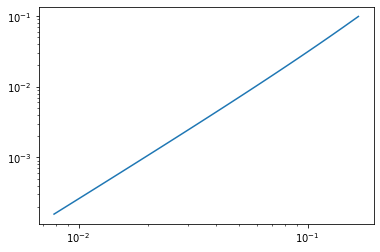

In [5]:
func = lambda x: np.sin(2*np.pi*x)*((2*np.pi)**2)
exact = lambda x: np.sin(2*np.pi*x)

error = []
Ms = list(range(5,128))
h = []

for M in Ms:
    Xq, approx, JxWq = fem(M, func)
    error.append(np.sqrt(np.einsum('q,q', (approx-exact(Xq))**2, JxWq)))
    h.append(1/(M+1))
    
plt.loglog(h, error)

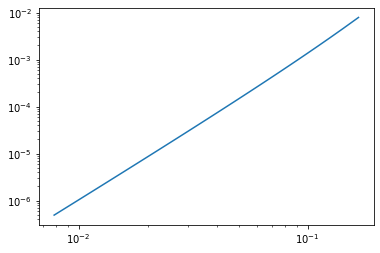

In [7]:
error = []
Ms = list(range(5,128))
h = []

for M in Ms:
    Xq, approx, JxWq = fem(M, func, degree=2)
    error.append(np.sqrt(np.einsum('q,q', (approx-exact(Xq))**2, JxWq)))
    h.append(1/(M+1))
    
plt.loglog(h, error)